設計温度 70.0℃, 設計波長 1.031 um での最適周期:
  SHG周期 (Λ_SHG): 7.2017 um
  SFG周期 (Λ_SFG): 1.9591 um

JITコンパイル中...
コンパイル完了。
計算完了 (カスケード): 1.3272 秒
計算完了 (SHG単独): 1.2016 秒


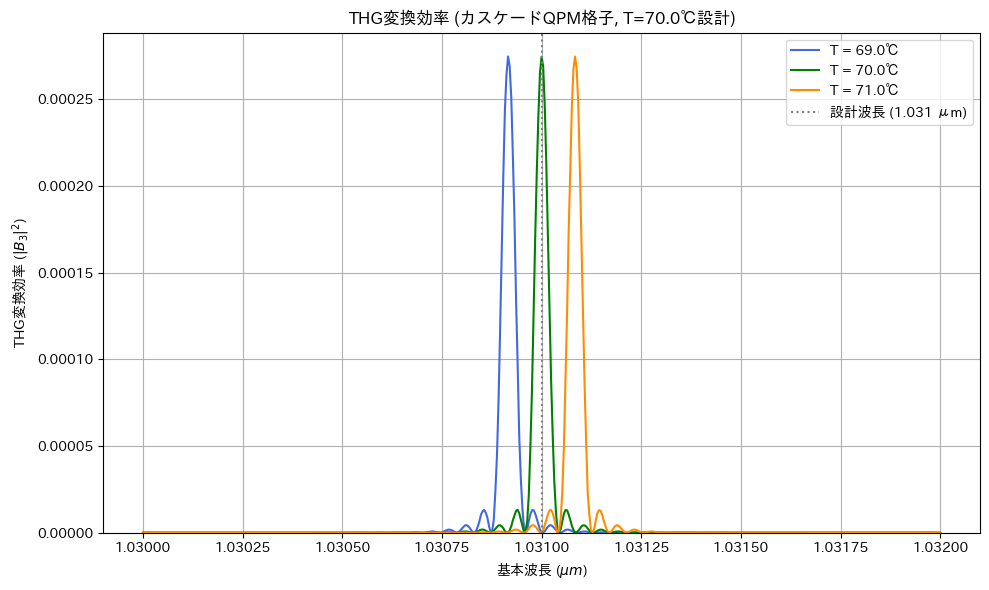

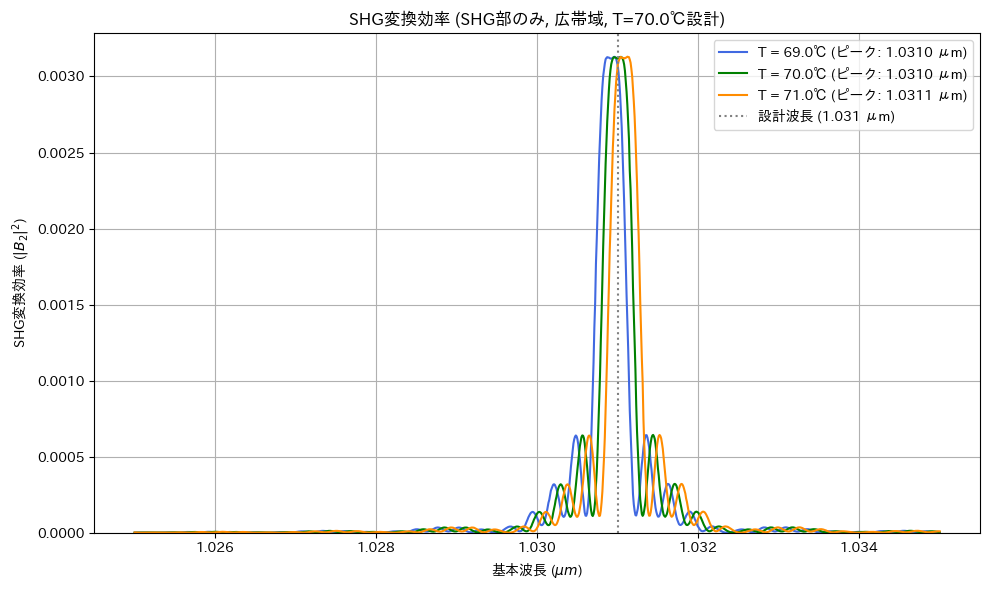

In [5]:
import jax.numpy as jnp
from jax import jit, vmap, lax
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

# --- 定数設定 ---
Z_SPLIT = 10000.0  # SHGセクションとSFGセクションの境界 (um)
Z_MAX = 22000.0    # 結晶の全長 (um)
KAPPA_MAG = 1.31e-5  # 非線形結合係数
DESIGN_TEMP_C = 70.0      # 設計温度 (QPM周期の計算に使用)
DESIGN_WAVELENGTH = 1.031  # 設計波長 (QPM周期の計算に使用)
SELLMEIER_PARAMS = {
    'a': jnp.array([4.5615, 0.08488, 0.1927, 5.5832, 8.3067, 0.021696]),
    'b': jnp.array([4.782e-07, 3.0913e-08, 2.7326e-08, 1.4837e-05, 1.3647e-07])
}


@jit
def sellmeier_n_eff(wl: jnp.ndarray, temp: jnp.ndarray) -> jnp.ndarray:
    """Sellmeier方程式を用いて実効屈折率を計算"""
    f = (temp - 24.5) * (temp + 24.5 + 2.0 * 273.16)
    lambda_sq = wl**2
    a, b = SELLMEIER_PARAMS['a'], SELLMEIER_PARAMS['b']
    n_sq = (a[0] + b[0] * f +
            (a[1] + b[1] * f) / (lambda_sq - (a[2] + b[2] * f)**2) +
            (a[3] + b[3] * f) / (lambda_sq - (a[4] + b[4] * f)**2) -
            a[5] * lambda_sq)
    return jnp.sqrt(n_sq)


@jit
def get_delta_k(wl1: jnp.ndarray, wl2: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
    """位相不整合量を計算"""
    wl_sum = (wl1 * wl2) / (wl1 + wl2)
    n1, n2, n_sum = sellmeier_n_eff(wl1, t), sellmeier_n_eff(
        wl2, t), sellmeier_n_eff(wl_sum, t)
    return 2.0 * jnp.pi * (n_sum / wl_sum - n1 / wl1 - n2 / wl2)


@jit
def get_L(delta_k1: jnp.ndarray, delta_k2: jnp.ndarray) -> jnp.ndarray:
    """線形演算子Lを生成"""
    return jnp.array([0.0, delta_k1 * 1j, (delta_k1 + delta_k2) * 1j], dtype=jnp.complex64)


@jit
def phi(omega: jnp.ndarray, h: float) -> jnp.ndarray:
    """
    IPM1予測子で使用される積分関数 Φ(Ω, h) = (e^(Ωh) - 1) / Ω を計算する。
    JAXのjitに対応するため、jnp.whereで条件分岐を処理する。
    """
    is_small = jnp.abs(omega) < 1e-9
    val_small = h + h**2 * omega / 2.0
    val_large = (jnp.exp(omega * h) - 1.0) / omega
    return jnp.where(is_small, val_small, val_large)


@jit
def predictor_ipm1(B_in: jnp.ndarray, h: float, kappa_val: float, L: jnp.ndarray) -> jnp.ndarray:
    """
    IPM1 (Interaction Picture Method 1st order) スキームの1ステップを計算する。
    (周波数項の計算を最適化)
    """
    B1n, B2n, B3n = B_in
    L1, L2, L3 = L

    omega_a = L2 - 2 * L1
    omega_b = L3 - L2 - L1

    delta_B_NL1 = 1j * kappa_val * jnp.exp(L1 * h) * (
        jnp.conj(B1n) * B2n * phi(omega_a, h) +
        jnp.conj(B2n) * B3n * phi(omega_b, h)
    )
    delta_B_NL2 = 1j * kappa_val * jnp.exp(L2 * h) * (
        B1n**2 * phi(-omega_a, h) +
        2 * jnp.conj(B1n) * B3n * phi(omega_b, h)
    )
    delta_B_NL3 = 1j * 3 * kappa_val * jnp.exp(L3 * h) * (
        B1n * B2n * phi(-omega_b, h)
    )
    delta_B_NL = jnp.array([delta_B_NL1, delta_B_NL2, delta_B_NL3])

    B_pred = jnp.exp(L * h) * B_in + delta_B_NL
    return B_pred


def generate_section(length: float, period: float, kappa_mag: float) -> jnp.ndarray:
    """指定された長さ、周期、結合係数でQPMセクションを生成する"""
    domain_len = period / 2.0
    num_domains = jnp.floor(length / domain_len).astype(int)
    h_values = jnp.full(num_domains, domain_len)
    alternating_signs = jnp.power(-1, jnp.arange(num_domains))
    kappa_values = kappa_mag * alternating_signs
    return jnp.stack([h_values, kappa_values], axis=1)


def simulate_superlattice(superlattice: jnp.ndarray, temperature: jnp.ndarray, wavelength: jnp.ndarray) -> jnp.ndarray:
    """
    指定された単一の波長、温度、格子で伝播を計算する。
    戻り値: [SHG効率, THG効率] の配列
    """
    B_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)
    delta_k1 = get_delta_k(wavelength, wavelength, temperature)
    delta_k2 = get_delta_k(wavelength, wavelength / 2.0, temperature)
    L = get_L(delta_k1, delta_k2)

    def ipm1_scan_step(B_carry, domain):
        h, kappa_val = domain
        B_next = predictor_ipm1(B_carry, h, kappa_val, L)
        return B_next, None

    B_final, _ = lax.scan(ipm1_scan_step, B_initial, superlattice)

    shg_eff = jnp.abs(B_final[1])**2
    thg_eff = jnp.abs(B_final[2])**2
    return jnp.array([shg_eff, thg_eff])


def run_and_plot():
    """シミュレーションを実行し、結果をプロットする"""
    # パラメータ設定
    wavelengths_narrow = jnp.linspace(1.03, 1.032, 501)
    wavelengths_wide = jnp.linspace(1.025, 1.035, 1001)
    temperatures = jnp.array([69.0, 70.0, 71.0])

    # 1. 設計条件での位相不整合量を計算
    delta_k_shg_design = get_delta_k(
        DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, DESIGN_TEMP_C)
    delta_k_sfg_design = get_delta_k(
        DESIGN_WAVELENGTH, DESIGN_WAVELENGTH / 2.0, DESIGN_TEMP_C)

    # 2. 最適なQPM周期を逆算
    qpm_period_shg = 2 * jnp.pi / delta_k_shg_design
    qpm_period_sfg = 2 * jnp.pi / delta_k_sfg_design

    print(f"設計温度 {DESIGN_TEMP_C}℃, 設計波長 {DESIGN_WAVELENGTH} um での最適周期:")
    print(f"  SHG周期 (Λ_SHG): {qpm_period_shg:.4f} um")
    print(f"  SFG周期 (Λ_SFG): {qpm_period_sfg:.4f} um")

    # --- 3. QPM格子の各部品を生成 ---
    shg_section_original = generate_section(Z_SPLIT, qpm_period_shg, KAPPA_MAG)

    shg_len = Z_SPLIT
    split_len = 0.165 * shg_len
    domain_len_shg = qpm_period_shg / 2.0
    split_idx = jnp.floor(split_len / domain_len_shg).astype(int)

    shg_part1 = shg_section_original[:split_idx]
    shg_part2 = shg_section_original[split_idx:]
    shg_part2_flipped = shg_part2.at[:, 1].set(-shg_part2[:, 1])

    shg_section = jnp.concatenate([shg_part1, shg_part2_flipped], axis=0)
    sfg_section = generate_section(Z_MAX - Z_SPLIT, qpm_period_sfg, KAPPA_MAG)
    blank_section = generate_section(Z_MAX - Z_SPLIT, qpm_period_sfg, 0.0)

    # --- 4. 部品を組み合わせて構造を定義し、パディングとスタックを行う ---
    superlattice_cascade = jnp.concatenate([shg_section, sfg_section], axis=0)
    superlattice_shg_only = jnp.concatenate(
        [shg_section, blank_section], axis=0)

    lattices = [superlattice_cascade, superlattice_shg_only]
    max_len = max(l.shape[0] for l in lattices)
    superlattices = jnp.stack([
        jnp.concatenate(
            [l, jnp.zeros((max_len - l.shape[0], 2), dtype=l.dtype)])
        for l in lattices
    ])

    # vmapを用いて計算を並列化
    vmapped_propagate = jit(
        vmap(vmap(vmap(simulate_superlattice, in_axes=(None, None, 0)),
                  in_axes=(None, 0, None)), in_axes=(0, None, None))
    )

    # --- 5. シミュレーション実行 ---
    print("\nJITコンパイル中...")
    # 一度ダミーデータで実行してコンパイルを完了させる
    vmapped_propagate(superlattices, temperatures,
                      wavelengths_wide).block_until_ready()
    print("コンパイル完了。")

    # カスケード構造のシミュレーション (THG用)
    start_time_cascade = time.time()
    results_cascade = vmapped_propagate(
        superlattices[0:1], temperatures, wavelengths_narrow)
    # [FIX] squeezeのaxisを修正し、結果を正しく抽出
    results_cascade_squeezed = jnp.squeeze(
        results_cascade.block_until_ready(), axis=0)
    # 結果の形状: (温度, 波長, [SHG効率, THG効率])
    thg_efficiencies = results_cascade_squeezed[:, :, 1]
    print(f"計算完了 (カスケード): {time.time() - start_time_cascade:.4f} 秒")

    # SHG単独構造のシミュレーション
    start_time_shg = time.time()
    results_shg_only = vmapped_propagate(
        superlattices[1:2], temperatures, wavelengths_wide)
    # [FIX] squeezeのaxisを修正し、結果を正しく抽出
    results_shg_squeezed = jnp.squeeze(
        results_shg_only.block_until_ready(), axis=0)
    # 結果の形状: (温度, 波長, [SHG効率, THG効率])
    shg_efficiencies_wide = results_shg_squeezed[:, :, 0]
    print(f"計算完了 (SHG単独): {time.time() - start_time_shg:.4f} 秒")

    # --- 6. 結果の抽出とプロット ---
    colors = ['royalblue', 'green', 'darkorange']

    # プロット1: THG効率 (狭帯域)
    plt.figure(figsize=(10, 6))
    plt.title(f"THG変換効率 (カスケードQPM格子, T={DESIGN_TEMP_C}℃設計)")

    for i, temp in enumerate(temperatures):
        plt.plot(wavelengths_narrow, thg_efficiencies[i],
                 label=f"T = {temp}℃", color=colors[i])

    plt.axvline(x=DESIGN_WAVELENGTH, color='gray', linestyle=':',
                label=f'設計波長 ({DESIGN_WAVELENGTH} μm)')
    plt.xlabel(r"基本波長 ($\mu m$)")
    plt.ylabel(r"THG変換効率 ($|B_3|^2$)")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.tight_layout()

    # プロット2: SHG効率 (広帯域)
    plt.figure(figsize=(10, 6))
    plt.title(f"SHG変換効率 (SHG部のみ, 広帯域, T={DESIGN_TEMP_C}℃設計)")

    for i, temp in enumerate(temperatures):
        peak_idx = jnp.argmax(shg_efficiencies_wide[i])
        peak_wl = wavelengths_wide[peak_idx]
        peak_eff = shg_efficiencies_wide[i][peak_idx]
        plt.plot(wavelengths_wide, shg_efficiencies_wide[i],
                 label=f"T = {temp}℃ (ピーク: {peak_wl:.4f} μm)", color=colors[i])

    plt.axvline(x=DESIGN_WAVELENGTH, color='gray', linestyle=':',
                label=f'設計波長 ({DESIGN_WAVELENGTH} μm)')
    plt.xlabel(r"基本波長 ($\mu m$)")
    plt.ylabel(r"SHG変換効率 ($|B_2|^2$)")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.tight_layout()

    plt.show()


if __name__ == '__main__':
    run_and_plot()